# Big Data in Finance: Part II <BR><BR> Lecture Notes 3: Compustat 
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu

<sub> Credit: lecture notes originally developed by Lira Mota

# Compustat

In this section we are going to:
1. Download a set of US firm's annual fundamentals;
2. Understand how the data is organized:
    1. Primary keys;
    2. Secondary keys;
    3. Data frequency;
    4. Others.        
2. Clean the data;
3. Construct important variables:
    1. Book Equity Value
    2. Asset Growth
    3. Operational Profitability

## How is the fundamentals data organized?

* We can display all tables in "comp" library.
* We are going to focus on the "funda" table: annual fundamentals.
* Others that are interesting to know: "namesd"

## Set Up

In [1]:
%matplotlib inline 

#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 200) # max number or rows to be displayed 

In [2]:
#%% Set WRDS Connection
db = wrds.Connection(wrds_username='khardnett') # make sure to configure wrds connector before hand.

Loading library list...
Done


### All tables in comp

In [3]:
compm_tables = db.list_tables(library="comp") # compd: Compustat daily update 

In [4]:
 pd.DataFrame({'tables':compm_tables}).head(100) # Transform libs to a Pandas data frame to have a better display.

,tables
0,aco_amda
1,aco_imda
2,aco_indfnta
3,aco_indfntq
4,aco_indfntytd
5,aco_indsta
6,aco_indstq
7,aco_indstytd
8,aco_notesa
9,aco_notesq


### All variables in comp.funda

In [5]:
db.describe_table(library="comp", table="funda")

Approximately 888799 rows in comp.funda.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),None
1,datadate,True,DATE,None
2,fyear,True,INTEGER,None
3,indfmt,True,VARCHAR(12),None
4,consol,True,VARCHAR(2),None
...,...,...,...,...
943,au,True,VARCHAR(8),None
944,auop,True,VARCHAR(8),None
945,auopic,True,VARCHAR(1),None
946,ceoso,True,VARCHAR(1),None


#### Where to check variable definitions?
1. [Compustat Data Items](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-annual/)
2. WRDS website: go to the (?) sign
3. What if we want to replicate a paper that says:

   "Earnings (E) is income before extraordinary items (Item 18) plus income statement deferred taxes (Item 50) minus preferred dividends (Item 19), if earnings are positive;" [Baker and Wurgler, JF 2006](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.2006.00885.x)

    * All previous documentation does not contain ITEM numbers
    * These are the legacy CST item numbers
    * You can find item reference [here](https://www.crsp.org/products/documentation/annual-data-industrial).
    
    

**Objective**

Create a data frame with company fundamentals necessary to replicate FF 2015:

1. Book Equity (BE)
2. Operating Profits (OP)
3. Investment (INV)

# Choose variables of interest

Compustat XpressFeed Variables 1/5:  
* AT      = Total Assets  
* CAPX    = Capital Expenditures  
* CEQ     = Common/Ordinary Equity - Total 
* COGS    = Cost of Goods Sold
* CSHO    = Common Shares Outstanding
* DLC     = Debt in Current Liabilities 
* DLCCH   = Current Debt - Changes
* DLTT    = Long-Term Debt - Total

Compustat XpressFeed Variables 2/5:
* DP      = Depreciation and Amortization
* DVC     = Divdends common/ordinary  
* DVP     = Dividends - Preferred/Preference
* GP      = Gross Profits
* IB      = Income Before Extraordinary Items
* ICAPT   = Invested Capital - Total
* ITCB    = Investment Tax Credit (Balance Sheet)  
* LT      = Total Liabilities

Compustat XpressFeed Variables 3/5:
* MIB     = Minority Interest (Balance Sheet)
* NAICS   = North American Industrial Classification System Variable Name
* NAICSH  = North American Industry Classification Codes - Historical Company Variable Name
* NI      = Net Income
* PPEGT   = "Property, Plant and Equipment - Total (Gross)"
* PRBA    = Postretirement Benefit Assets (from separate pension annual file) 
* PRSTKCC = Purchase of Common Stock (Cash Flow)                   
* PSTKRV  = Preferred Stock Redemption Value

Compustat XpressFeed Variables 4/5:
* PSTK    = Preferred/Preference Stock (Capital) - Total (kd: = par?)               
* PSTKL   = Preferred Stock Liquidating Value     
* PSTKRV  = Preferred Stock Liquidating Value          
* RE      = Retained Earnings
* REVT    = Revenue - Total
* SALE    = Sales/Turnover Net
* SEQ     = Shareholders Equity   
* SIC     = Standard Industrial Classification Code

Compustat XpressFeed Variables 5/5:
* TXDB    = Deferred Taxes Balance Sheet
* TXDI    = Income Taxes - Deferred
* TXDITC  = Deferred Taxes and Investment Tax Credit                        
* WCAPCH  = Working Capital Change - Total
* XINT    = Interest and Related Expense - Total 
* XLR     = Staff Expense - Total
* XRD     = Research and Development Expense 
* XSGAQ   = Selling, General and Administrative Expenses (millions)  

# Download Compustat FUNDA

In [6]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga']


query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=1980;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

Always look at your data

In [7]:
# Gerneral Look
compa.head()  

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,seq,sich,txdb,txdi,txditc,wcapch,xint,xlr,xrd,xsga
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983,12,14.080,3.367,7.823,...,7.823,NaN,0.000,0.144,0.000,3.618,0.763,NaN,0.0,16.435
4,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984,12,16.267,5.496,8.962,...,8.962,NaN,0.357,0.275,0.357,-2.993,0.661,NaN,NaN,20.628


In [8]:
# Have a sense about missings
compa['at'].isnull().mean()*100

17.65173102572721

In [9]:
compa.gvkey.nunique()

41669

In [10]:
compa.groupby('fyear').gvkey.nunique()

fyear
1980     6889
1981     7058
1982     7685
1983     7996
1984     8243
1985     8599
1986     9017
1987     9225
1988     9333
1989     9343
1990     9571
1991     9966
1992    10705
1993    11482
1994    11899
1995    12492
1996    12624
1997    12437
1998    12554
1999    12531
2000    12093
2001    11583
2002    11252
2003    11066
2004    10900
2005    10856
2006    10877
2007    10874
2008    10688
2009    10642
2010    10861
2011    11268
2012    11672
2013    11828
2014    11663
2015    11500
2016    11377
2017    11294
2018    11388
2019    11652
2020    11934
2021    12150
2022    12065
2023     5948
Name: gvkey, dtype: int64

# Data Consistency 

## Primary Keys


* We are looking at Annual data
* Logic says that that we should have one company (gvkey) per year (fyear)
* But remember, the primary key for funda is (gvkey and datadate)
* Question: Can a firm have two datadate for the same year?


In [11]:
# It is always good to check if we have the right PK
compa.duplicated(['gvkey', 'datadate']).sum()

0

In [12]:
# Is (gvkey, fyear) PK?
compa[compa.duplicated(['gvkey', 'fyear'])]

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,seq,sich,txdb,txdi,txditc,wcapch,xint,xlr,xrd,xsga
66624,006557,1982-12-31,LAIDLAW INTERNATIONAL INC,LI.3,50730R102,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66626,006557,1983-12-31,LAIDLAW INTERNATIONAL INC,LI.3,50730R102,1983,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301572,039310,2021-01-31,VICTORIAS SECRET AND CO,VSCO,926400102,2020,1,4229.0,127.0,891.0,...,891.0,5621.0,19.0,-64.0,19.0,NaN,6.0,NaN,0.0,1621.0
343119,066552,2018-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2018,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343125,066552,2019-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2019,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343139,066552,2010-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2010,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343141,066552,2011-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2011,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343143,066552,2012-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2012,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343145,066552,2013-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2013,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343147,066552,2014-12-31,LIMITLESS X HOLDINGS INC,VYBE,090622309,2014,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Example of a company that have two reports for the same year
compa.loc[compa.gvkey=='006557',['gvkey','datadate','fyear','fyr','conm', 'at']]

,gvkey,datadate,fyear,fyr,conm,at
66621,006557,1980-08-31,1980,8,LAIDLAW INTERNATIONAL INC,201.266
66622,006557,1981-08-31,1981,8,LAIDLAW INTERNATIONAL INC,242.081
66623,006557,1982-08-31,1982,8,LAIDLAW INTERNATIONAL INC,251.360
66624,006557,1982-12-31,1982,12,LAIDLAW INTERNATIONAL INC,NaN
66625,006557,1983-08-31,1983,8,LAIDLAW INTERNATIONAL INC,328.891
66626,006557,1983-12-31,1983,12,LAIDLAW INTERNATIONAL INC,NaN
66627,006557,1984-08-31,1984,8,LAIDLAW INTERNATIONAL INC,426.880
66628,006557,1985-08-31,1985,8,LAIDLAW INTERNATIONAL INC,652.477
66629,006557,1986-08-31,1986,8,LAIDLAW INTERNATIONAL INC,901.769
66630,006557,1992-08-31,1992,8,LAIDLAW INTERNATIONAL INC,3658.935


In [14]:
# How to deal with duplicates? Keep last available entry (datadate)
compa.dropna(subset=['fyear'], inplace=True)
compa.sort_values(['gvkey','fyear','at'], inplace=True)
compa = compa[~compa.duplicated(['gvkey', 'fyear'], keep='first')]

In [15]:
# Always check your result
compa.duplicated(['gvkey', 'fyear']).sum()

0

# Calculate Variables of Interest

## Book Equity

Daniel, Mota, Rottke, Santos (RFS, 2020) BE definition:

Stockholders book equity, minus the book value of preferred stock, plus balance sheet deferred taxes (if available and fiscal year is < 1993), minus investment tax credit (if available), minus post-retirement benefit assets (PRBA) if available. 

Stockholders book equity is shareholder equity (SEQ), common equity (CEQ) plus preferred stock (PSTK) or total
assets (AT) minus liabilities (LT) plus minority interest (MIB, if available) (depending on availability, in that order). 

Book value of preferred stock is redemption (PSTKRV), liquidation (PSTKL), or par value (PSTK) (depending on availability, in that order). 

Deferred taxes is deferred taxes and investment tax credit (TXDITC) or deferred taxes and investment tax credit (TXDB) plus investment tax credit (ITCB) (depending on availability, in that order).


In [16]:
# Calculating BE
# Shareholder Equity
compa['se'] = compa['seq']

# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compa['se'].fillna((compa['ceq'] + compa['pstk']), inplace=True)

# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compa['se'].fillna((compa['at'] - compa['lt'] + compa['mib'].fillna(0)), inplace=True)
  

In [17]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compa['ps'] = compa['pstkrv']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
compa['ps'].fillna(compa['pstkl'], inplace=True)
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compa['ps'].fillna(compa['pstk'], inplace=True)

In [18]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compa['dt'] = compa['txditc']

# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing
compa['dt'].fillna((compa['txdb'].fillna(0) + compa['itcb'].fillna(0)), inplace=True)
# If all measures are missing, set n  to missing
compa.loc[pd.isnull(compa['txditc']) & pd.isnull(compa['txdb']) & pd.isnull(compa['itcb']), 'dt'] = np.nan

compa.loc[compa['fyear'] >= 1993, 'dt'] = 0

In [19]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compa['be'] = (compa['se']  # shareholder equity must be available, otherwise BE is missing
               - compa['ps']  # preferred stock must be available, otherwise BE is missing
               + compa['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

**Always look at your data...**

In [20]:
# Missings
compa.be.isnull().mean()  

0.17822428706003254

<Axes: >

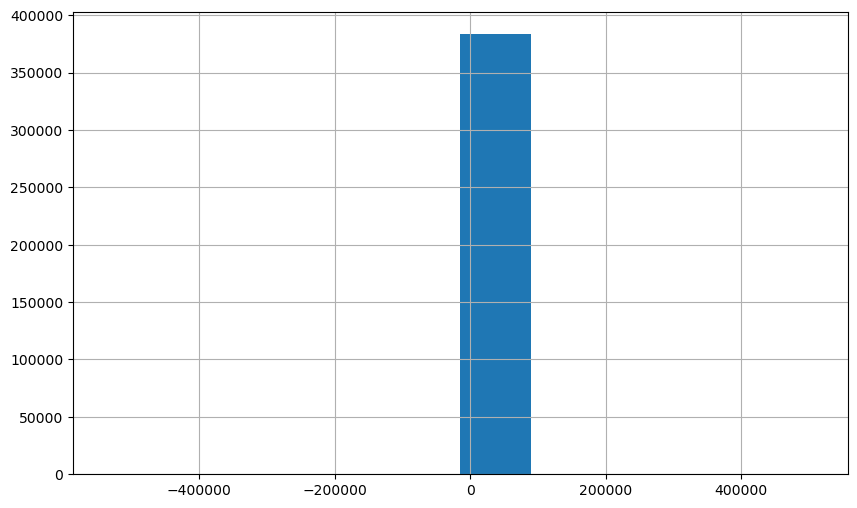

In [21]:
compa.be.hist() 

In [22]:
# Does it make sense to have a negative BE?
(compa.be<0).mean()   

0.0965059518711998

<Axes: >

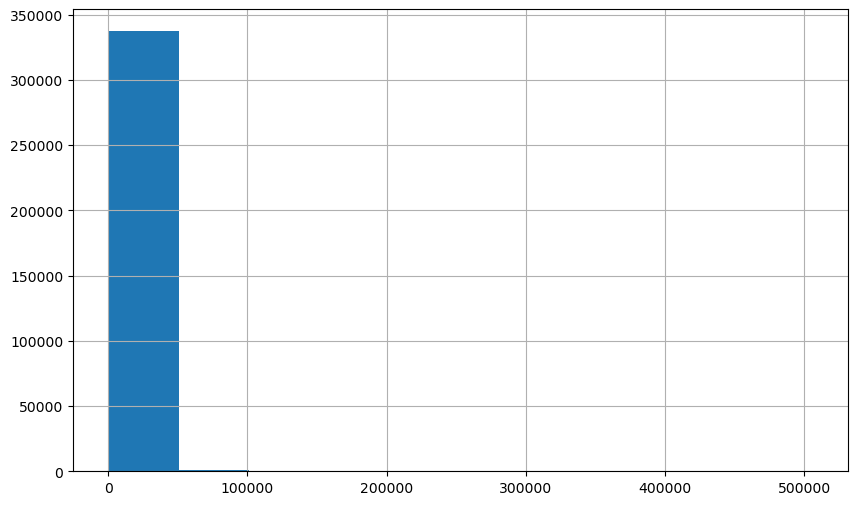

In [23]:
compa[compa.be>0].be.hist()

<Axes: >

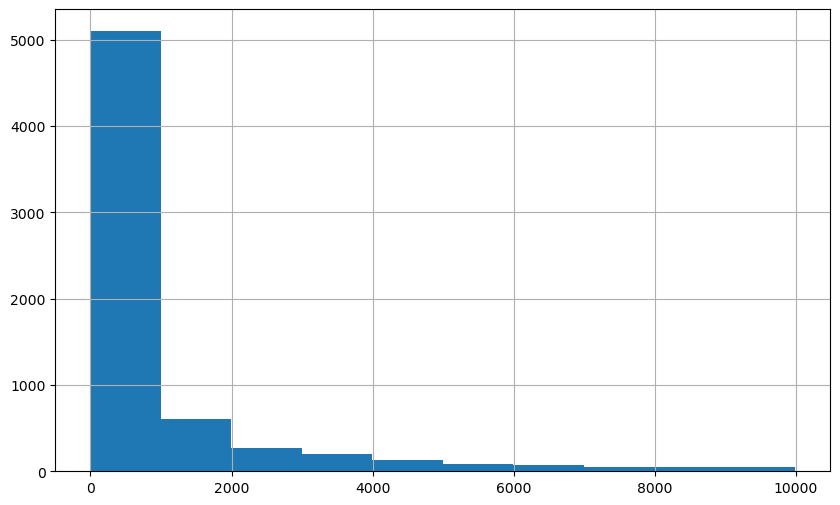

In [24]:
compa[(compa.be>0)&(compa.be<10e3)&(compa.fyear==2017)].be.hist()

## Operating Profitability (OPBE)

Daniel, Mota, Rottke, Santos (RFS, 2020) OPBE definition:

Operating profits to book equity (BE) ratio. 

Operating profits is sales (SALE) minus cost of goods sold (COGS), minus selling, general, and administrative expenses (XSGA),
minus interest expense (XINT). In order to be non-missing, SALE must be non-missing, at least one of the other entries must be non-missing and BE must be greater than zero.

In [25]:
# COST = COGS + XSGA + XINT 
compa['cost'] = compa[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
compa.loc[compa[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

In [26]:
# OP = SALE -COST    
compa['op'] = compa['sale']-compa['cost']

**Always look at your data...**

In [27]:
# Look at missings
compa.op.isnull().mean()

0.18215509120493278

<Axes: >

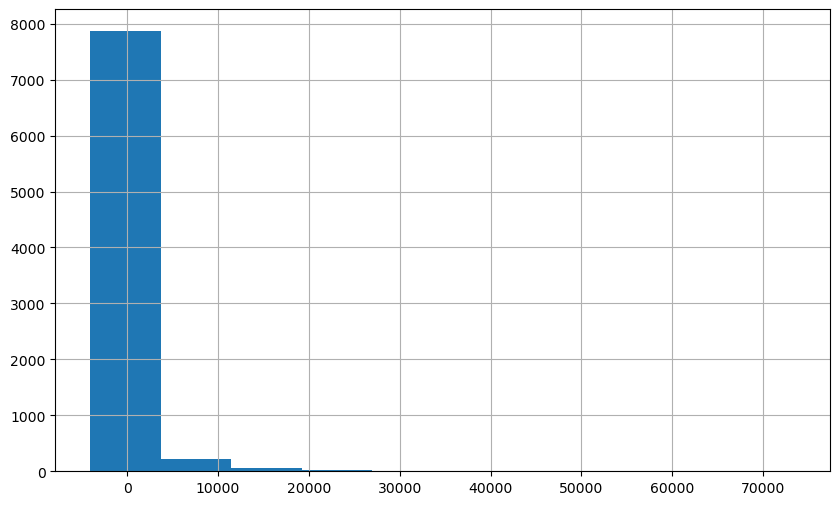

In [28]:
compa[compa.fyear==2017].op.hist()

In [29]:
# Which was the most profitable company in 2020?
compa.loc[compa[compa.fyear==2021].op.idxmax(),['gvkey','conm','op','be','at']]

gvkey                002176
conm     BERKSHIRE HATHAWAY
op                 121409.0
be                 506199.0
at                 958784.0
Name: 14096, dtype: object

<Axes: title={'center': "Apple's OP"}, xlabel='fyear'>

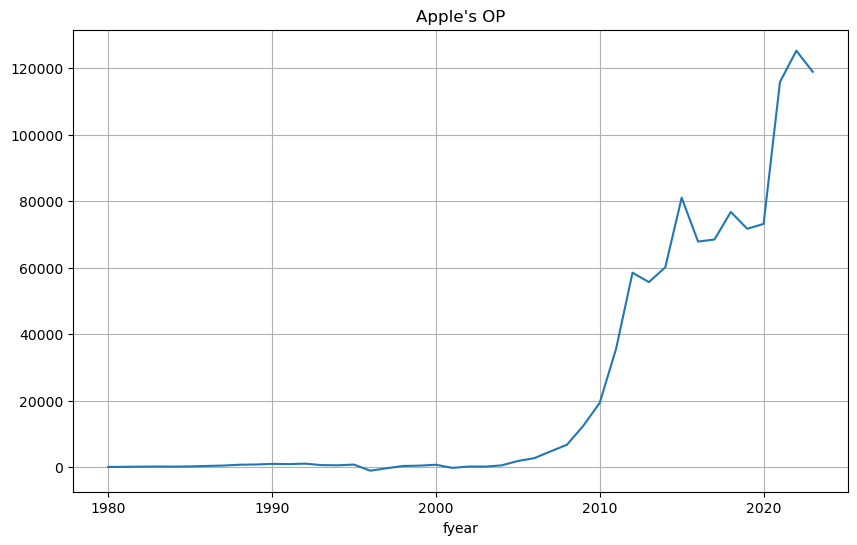

In [30]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').op.plot(title = "Apple's OP", grid=True)

In [31]:
# Calculate OPBE
compa.loc[(compa.be > 0), 'opbe'] = compa['op']/compa['be']

**What do we do now?**

Look at the data...

In [32]:
# Look at missings
compa.opbe.isnull().mean()

0.2802282264280209

<Axes: >

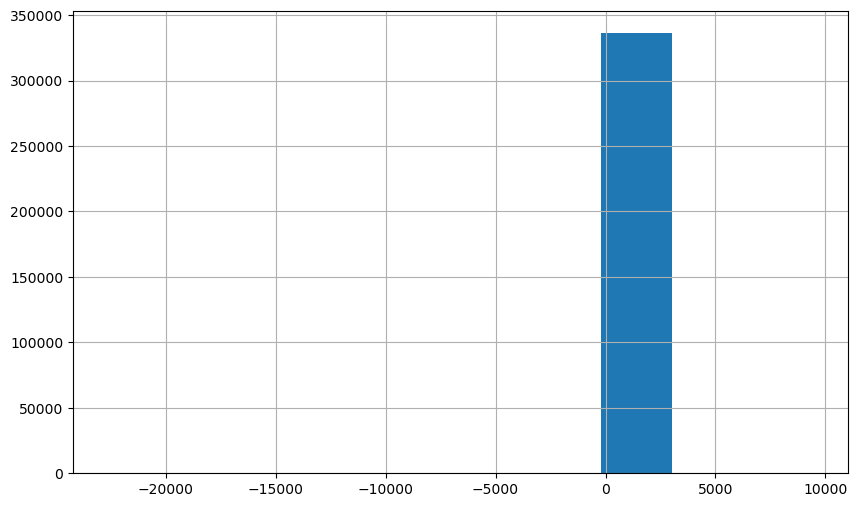

In [33]:
# Be careful with ratios
compa.opbe.hist()

<Axes: title={'center': "Apple's OPBE"}, xlabel='fyear'>

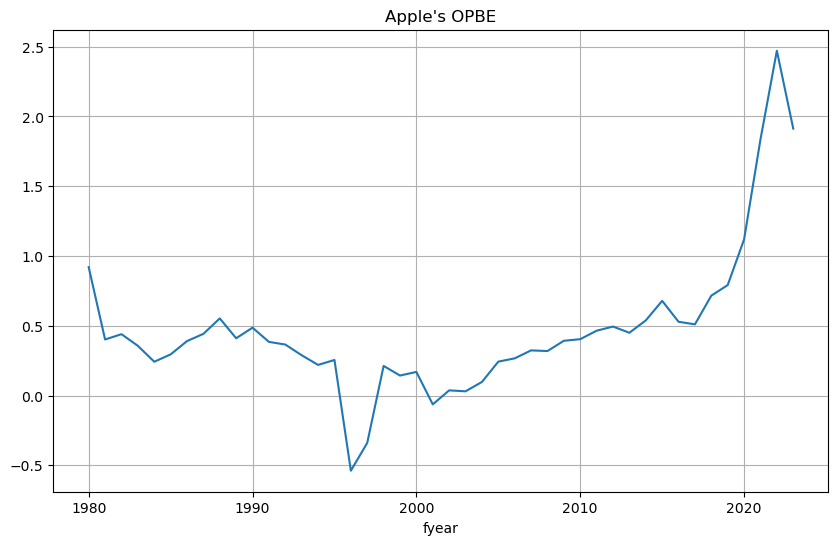

In [34]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').opbe.plot(title = "Apple's OPBE", grid=True)

<Axes: xlabel='fyear'>

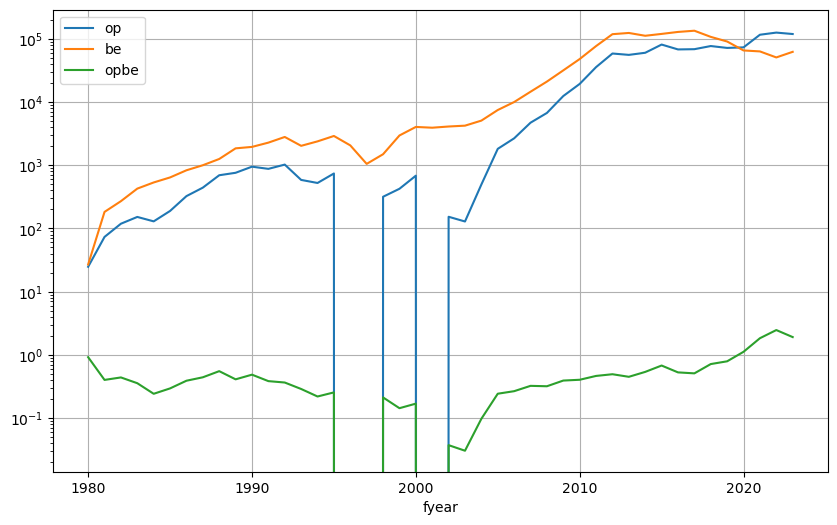

In [35]:
# plot op, be, and op/be on log scale and see difference
compa[compa.gvkey=='001690'].set_index('fyear')[['op', 'be', 'opbe']].plot(label = ["Apple's OPBE"], grid=True, logy=True)

## Investment (INV)

Daniel, Mota, Rottke, Santos (RFS, 2020) OP definition:

Total asset (AT) growth $(AT_t/AT_{t-1} - 1)$. 

We consider PERMCO as company's identification key. AT must be greater than zero to be not missing.


In [36]:
# Calculate lag assets and investment
compa.sort_values(['gvkey', 'fyear'], inplace=True)
compa['at_lag'] = compa.groupby('gvkey').at.shift(1)
compa['inv'] = (compa['at'] - compa['at_lag']) / compa['at_lag']

In [37]:
compa.loc[compa.at_lag==0, 'inv'] = np.nan

What if compa has missing years?

In [38]:
compa['fdiff'] = compa.groupby('gvkey').fyear.diff()

In [39]:
compa[(compa.fdiff>1)][['gvkey','fyear','fdiff', 'at','at_lag', 'inv']]

,gvkey,fyear,fdiff,at,at_lag,inv
21604,002820,2001,4.0,117.090,NaN,NaN
25522,003279,2011,19.0,NaN,1.269,NaN
29668,003469,2002,4.0,406.677,NaN,NaN
33594,003819,2011,19.0,NaN,2.295,NaN
36308,004049,2000,4.0,905.890,NaN,NaN
39471,004292,2012,3.0,0.704,0.534,0.318352
40018,004341,2000,2.0,0.000,NaN,NaN
40777,004412,2004,2.0,213.432,218.681,-0.024003
40780,004412,2008,2.0,219.640,203.755,0.077961
44515,004707,1996,3.0,14.416,NaN,NaN


In [40]:
# Check one case of skipping years
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv','fdiff']]  

,gvkey,fyear,at,at_lag,inv,fdiff
55645,005681,1983,6803.074,NaN,NaN,NaN
55657,005681,1984,8885.500,6803.074,0.306101,1.0
55667,005681,1985,10018.598,8885.500,0.127522,1.0
55682,005681,1986,12074.598,10018.598,0.205218,1.0
55691,005681,1987,14109.098,12074.598,0.168494,1.0
55704,005681,1988,17008.699,14109.098,0.205513,1.0
55711,005681,1989,17766.699,17008.699,0.044565,1.0
55077,005681,1990,18259.500,17766.699,0.027737,1.0
55204,005681,1991,13885.098,18259.500,-0.239569,1.0
55718,005681,1995,26.851,13885.098,-0.998066,4.0


In [41]:
# Input missings
filter_inv = (compa['at']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv,['inv']] = np.nan
del(filter_inv)

In [42]:
# Check one case of skipping years (again)
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv']]

,gvkey,fyear,at,at_lag,inv
55645,005681,1983,6803.074,NaN,NaN
55657,005681,1984,8885.500,6803.074,0.306101
55667,005681,1985,10018.598,8885.500,0.127522
55682,005681,1986,12074.598,10018.598,0.205218
55691,005681,1987,14109.098,12074.598,0.168494
55704,005681,1988,17008.699,14109.098,0.205513
55711,005681,1989,17766.699,17008.699,0.044565
55077,005681,1990,18259.500,17766.699,0.027737
55204,005681,1991,13885.098,18259.500,-0.239569
55718,005681,1995,26.851,13885.098,NaN


**What do we do now?**

In [43]:
# Look at missings
compa.inv.isnull().mean()

0.25481288002055325

In [44]:
compa.inv.max()

11492999.0

In [45]:
compa.inv.min()

-0.9999992483516351

In [46]:
# Be careful with ratios
compa.loc[compa.inv.idxmax(axis=0),['gvkey','conm','fyear','at','at_lag','inv']]

gvkey                         039128
conm      BROOKFIELD REINSURANCE LTD
fyear                           2021
at                           11493.0
at_lag                         0.001
inv                       11492999.0
Name: 301220, dtype: object

<Axes: >

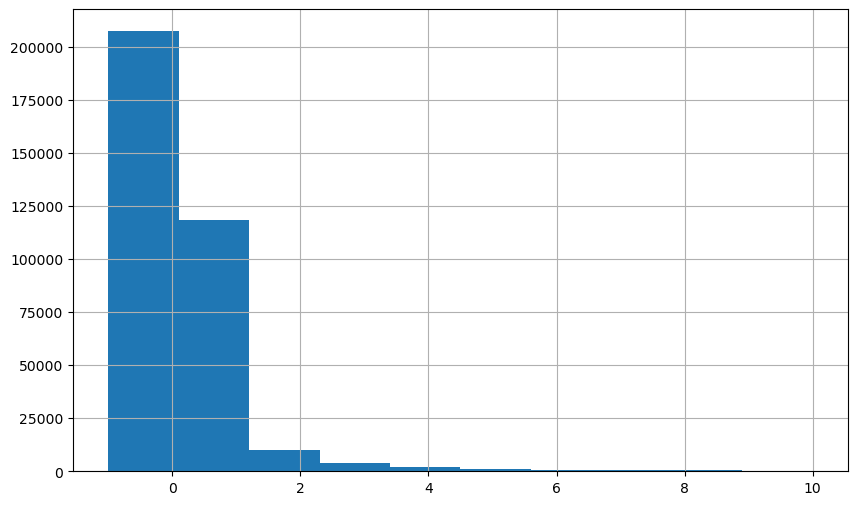

In [47]:
 # What explains such large inv?
compa[compa.inv<10].inv.hist() 

# Is Asset Growth Investment?

* See Cooper, Gulen, Schill, JF (2008);
* What is asset growth capturing other than investment? 
    * Mergers;
    * Issuance;
    * Spin-offs.
* Is it really investments that forecast future stock returns?

In [48]:
# A more traditional measure of investment: CAPX
compa['inv_capx'] = compa['capx']/compa['at_lag']
filter_inv_capx = (compa['capx']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv_capx,'inv_capx']=np.nan

<Axes: title={'center': "Apple's Investment"}, xlabel='fyear'>

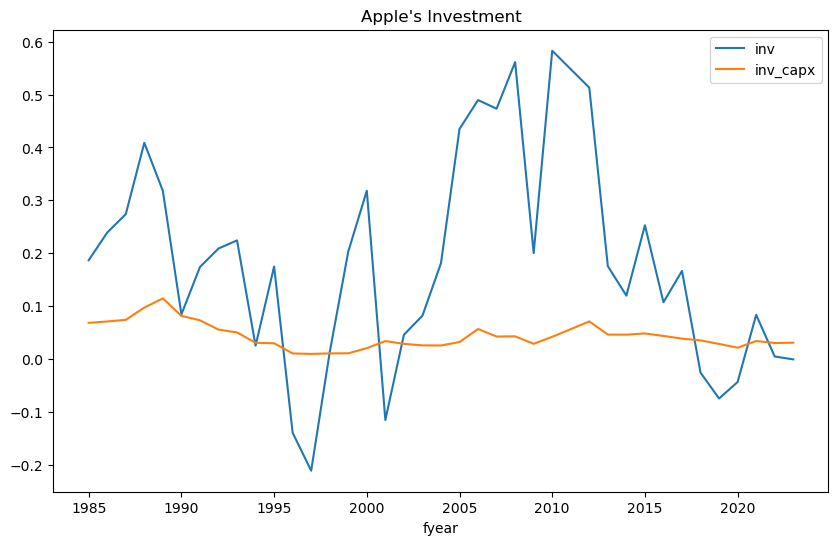

In [49]:
# Difference for Apple
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),['fyear','inv','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment") 

<Axes: title={'center': "Apple's Investment"}, xlabel='fyear'>

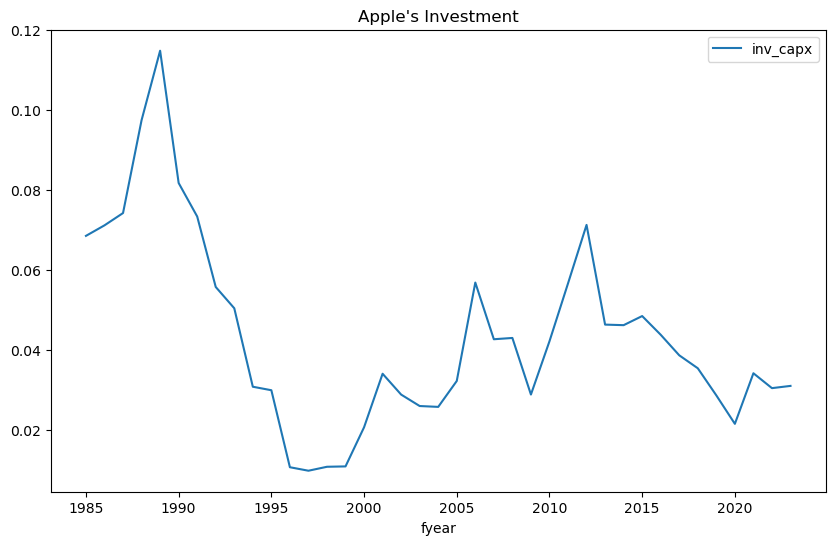

In [50]:
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),
          ['fyear','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment")

# Save Output

In [51]:
compa.columns

Index(['gvkey', 'datadate', 'conm', 'tic', 'cusip', 'fyear', 'fyr', 'at',
       'capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib',
       'itcb', 'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl',
       'pstkrv', 're', 'revt', 'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc',
       'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost',
       'op', 'opbe', 'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')

In [52]:
compa.to_pickle(path='./compa_annual.pkl')